Question 4

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from numpy import linalg

Part A

((< cv2.DMatch 000001E417B27D90>, < cv2.DMatch 000001E408578990>), (< cv2.DMatch 000001E40857BED0>, < cv2.DMatch 000001E408578F30>), (< cv2.DMatch 000001E40857BF50>, < cv2.DMatch 000001E40857BD30>), (< cv2.DMatch 000001E40857BC70>, < cv2.DMatch 000001E41C081670>), (< cv2.DMatch 000001E41C0817B0>, < cv2.DMatch 000001E41C081850>))


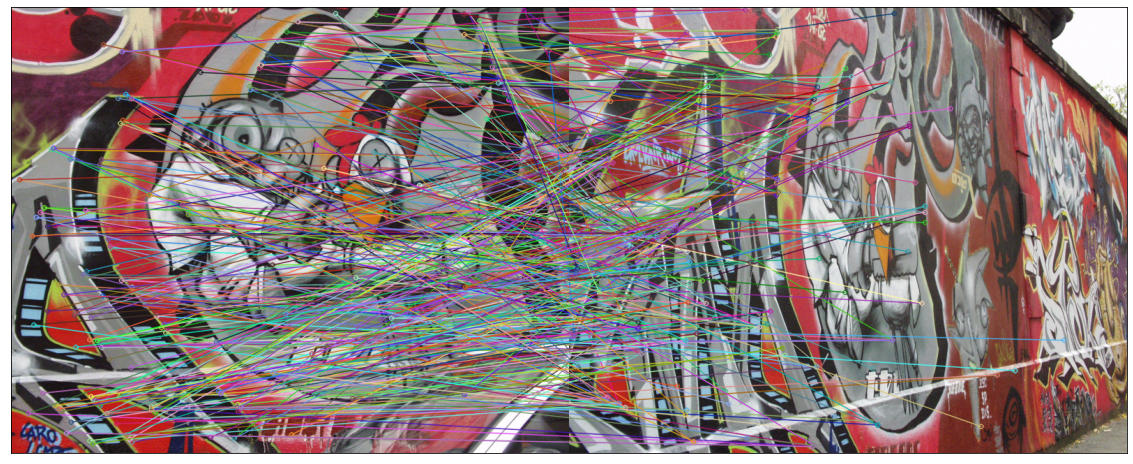

In [3]:
import cv2  as cv
import numpy as np
import matplotlib.pyplot as plt


img1 = cv.imread('./New folder/img1.ppm')
img5 = cv.imread('./New folder/img5.ppm')

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create()
bf = cv.BFMatcher()

key1, des1 = sift.detectAndCompute(img1, None)
key5, des5 = sift.detectAndCompute(img5, None)

matches = bf.knnMatch(des1, des5, k=2)
print(matches[:5])
matches = sorted(matches, key=lambda x:x[0].distance)

out_img = cv.drawMatchesKnn(img1, key1, img5, key5, matches[:200], img5, flags=2) #only draw best 200 matches

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(out_img)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

Part B

In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def Hormo_cal(arr):
    A = []
    for i in range(len(arr)):
        x1, y1, x2, y2 = arr[i, 0], arr[i, 1], arr[i, 2], arr[i, 3]
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])

    A = np.matrix(A)
    U, S, V = np.linalg.svd(A)
    H = np.reshape(V[-1], (3, 3))
    H = (1/H.item(8))*H
    return H

def Distanse_cal(H, correspondence):
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(H, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)


def RANSAC(corres,threshold):
    max_inliers = []
    homography = []

    #(int(np.log(1 - 0.95)/np.log(1 - (1 - 0.5)**4)))

    for i in range(100):
        corr1 = corres[np.random.randint(0, len(corres))]
        corr2 = corres[np.random.randint(0, len(corres))]
        arr = np.vstack((corr1, corr2))
        corr3 = corres[np.random.randint(0, len(corres))]
        arr = np.vstack((arr, corr3))
        corr4 = corres[np.random.randint(0, len(corres))]
        arr = np.vstack((arr, corr4))
        
        
        h = Hormo_cal(arr)
        inliers = np.zeros((1,4))
        
        for j in range(len(corres)):
            distance = Distanse_cal(h, corres[j])
            if distance < 5:
                inliers = np.vstack((inliers,corres[j]))
               
        inliers = np.delete(inliers,0,0)

        if len(inliers) > threshold:
            max_inliers = inliers
            homography = Hormo_cal(max_inliers)
       
    return homography,max_inliers

img_lst = []
for i in range(1,6):
    img = cv.imread('./New folder/img'+str(i)+'.ppm')
    img_lst.append(img)


homo = []
estimated_threshold = 100
sift = cv.SIFT_create()
bf = cv.BFMatcher()

for i in range(4):
    correspondence = []
    keypoint1, desig1 = sift.detectAndCompute(img_lst[i],None)
    keypoint2, desig2 = sift.detectAndCompute(img_lst[i+1],None)
    matching_points = bf.knnMatch(desig1, desig2, k=2)
    keypoints = [keypoint1, keypoint2]

    for match in matching_points:
        (x1, y1) = keypoints[0][match[0].queryIdx].pt
        (x2, y2) = keypoints[1][match[0].trainIdx].pt
        correspondence.append([x1, y1, x2, y2])

    corres = np.matrix(correspondence)
    H,inliers =RANSAC(corres,estimated_threshold)
    homo.append(H)

final = homo[3]@homo[2]@homo[1]@homo[0]
final = (1/final.item(8))*final
print('Homography calculated \n',final)
print("--------------------------------------------------------------------------------------------------------------------------------")
print('Original Homography\n',open('./New folder/H1to5p').read())

Homography calculated 
 [[ 4.20808955e-01 -1.86095123e-02  2.59927357e+02]
 [ 7.77480685e-02  9.65014317e-01  3.36459323e+01]
 [ 1.88190336e-04 -1.66921601e-04  1.00000000e+00]]
--------------------------------------------------------------------------------------------------------------------------------
Original Homography
    6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00



Part C

(-0.5, 799.5, 639.5, -0.5)

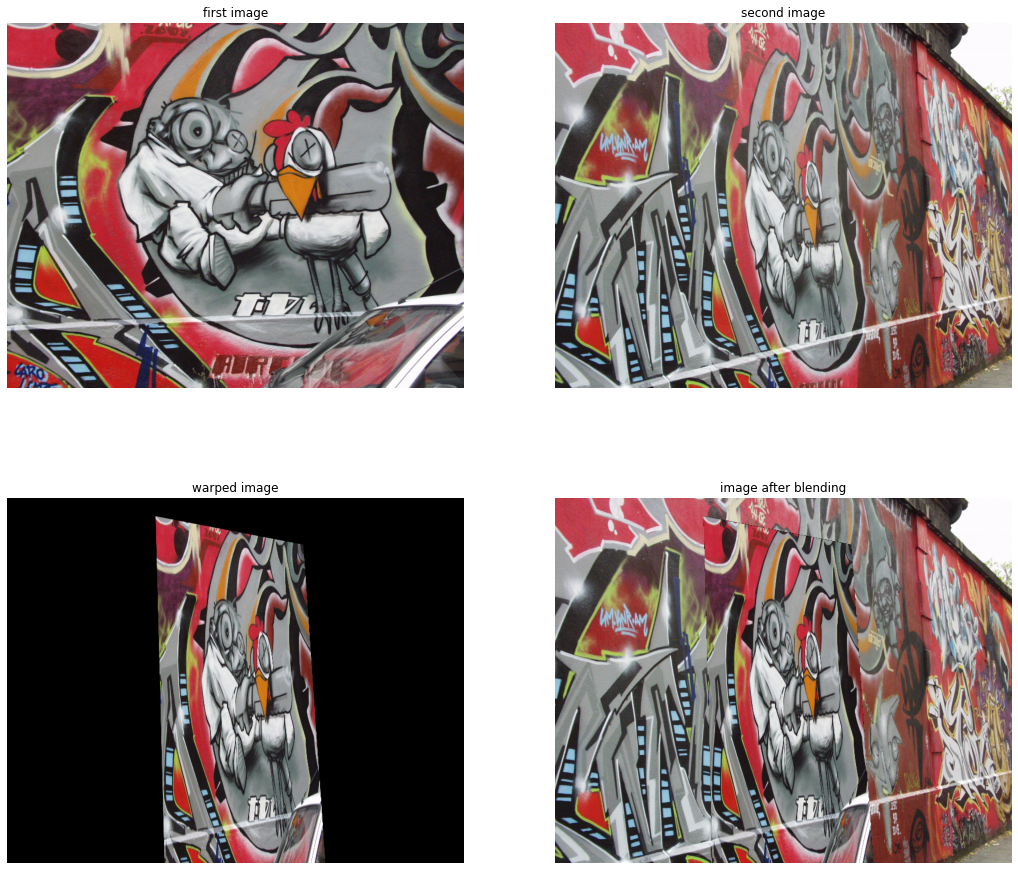

In [5]:
calculated_H = final

img1 = cv.imread('./New folder/img1.ppm')
img5 = cv.imread('./New folder/img5.ppm')



fig,ax=plt.subplots(2,2,figsize=(18,16))
ax[0,0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[0,0].set_title('first image')
ax[0,0].axis('off')
ax[0,1].imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
ax[0,1].set_title('second image')
ax[0,1].axis('off')

image_perspective = cv.warpPerspective(img1, calculated_H, (img5.shape[1], img5.shape[0]))

ax[1,0].imshow(cv.cvtColor(image_perspective, cv.COLOR_BGR2RGB))
ax[1,0].set_title('warped image')
ax[1,0].axis('off')

threshold, mask = cv.threshold(cv.cvtColor(image_perspective, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective, 1, 0)

ax[1,1].imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB)) 
ax[1,1].set_title('image after blending')
ax[1,1].axis('off') 